In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("training.1600000.processed.noemoticon.csv",header=None, names=cols,  encoding='latin-1')

In [3]:
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.shape

(1600000, 6)

In [5]:
df.sentiment.value_counts()

sentiment
0    800000
4    800000
Name: count, dtype: int64

In [6]:
df.drop(["id","date","query_string","user"],axis=1,inplace=True)

In [7]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [8]:
df[df.sentiment == 0].head(15)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [9]:
df[df.sentiment == 4].head(15)


,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone
800005,4,@ProductOfFear You can tell him that I just bu...
800006,4,@r_keith_hill Thans for your response. Ihad al...
800007,4,"@KeepinUpWKris I am so jealous, hope you had a..."
800008,4,"@tommcfly ah, congrats mr fletcher for finally..."
800009,4,@e4VoIP I RESPONDED Stupid cat is helping me ...


In [10]:
df["pre_clean_len"] = [len(t) for t in df.text]

In [11]:
df["pre_clean_len"].sort_values(ascending=False)

1295281    374
1484882    369
380539     359
1582941    359
650945     348
          ... 
1071086      6
1229947      6
4233         6
310554       6
1050599      6
Name: pre_clean_len, Length: 1600000, dtype: int64

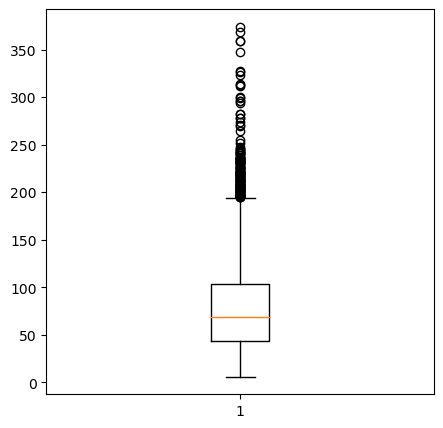

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

In [13]:
df.text[343]

'@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [14]:
df.text[226]

'Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [15]:
df.text[279]

"Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. "

In [16]:
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [17]:
nums = [0,400000,800000,1200000,1600000]
print ("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[4]):
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, nums[4] )  )                                                                  
    clean_tweet_texts.append(tweet_cleaner_updated(df['text'][i]))

Cleaning and parsing the tweets...



C:\Users\terri\AppData\Local\Temp\ipykernel_16836\1084544591.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


Tweets 10000 of 1600000 has been processed
Tweets 20000 of 1600000 has been processed
Tweets 30000 of 1600000 has been processed
Tweets 40000 of 1600000 has been processed
Tweets 50000 of 1600000 has been processed
Tweets 60000 of 1600000 has been processed
Tweets 70000 of 1600000 has been processed
Tweets 80000 of 1600000 has been processed
Tweets 90000 of 1600000 has been processed
Tweets 100000 of 1600000 has been processed
Tweets 110000 of 1600000 has been processed
Tweets 120000 of 1600000 has been processed
Tweets 130000 of 1600000 has been processed
Tweets 140000 of 1600000 has been processed
Tweets 150000 of 1600000 has been processed
Tweets 160000 of 1600000 has been processed
Tweets 170000 of 1600000 has been processed
Tweets 180000 of 1600000 has been processed
Tweets 190000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 210000 of 1600000 has been processed
Tweets 220000 of 1600000 has been processed
Tweets 230000 of 1600000 has been process

In [18]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.shape
clean_df.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [19]:
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [20]:
my_df["target"].count()

1600000

In [21]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596041 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [22]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596041 non-null  object
 1   target  1596041 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


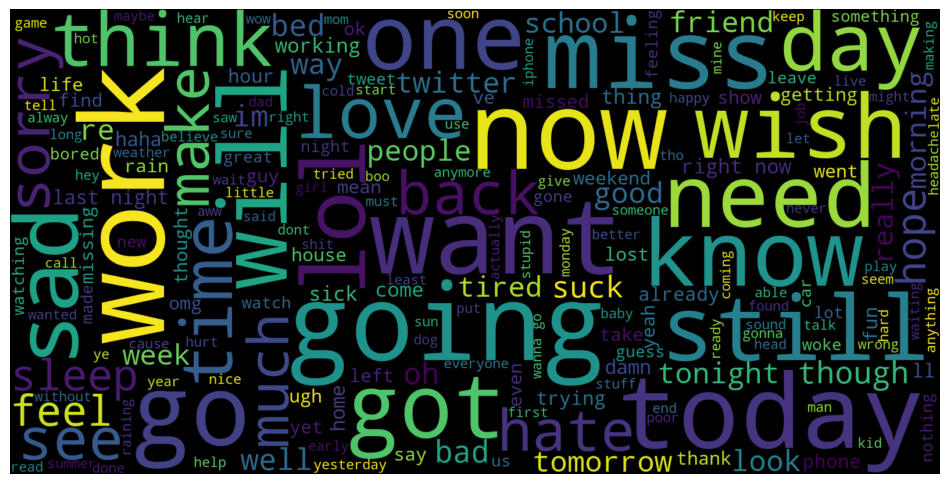

In [23]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=" ")

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [24]:
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print (t)

ahh ive always wanted to see rent love the soundtrack
meh almost lover is the exception this track gets me depressed every time
awe love you too am here miss you
damn the grind is inspirational and saddening at the same time do not want you to stop cuz like what do much love
missing you babe but as long as your alive happy ya tired my love imma try to sleep hopefully you had headstart
love the french tell people here in the south qtr french and they snarl at me french are beautiful people


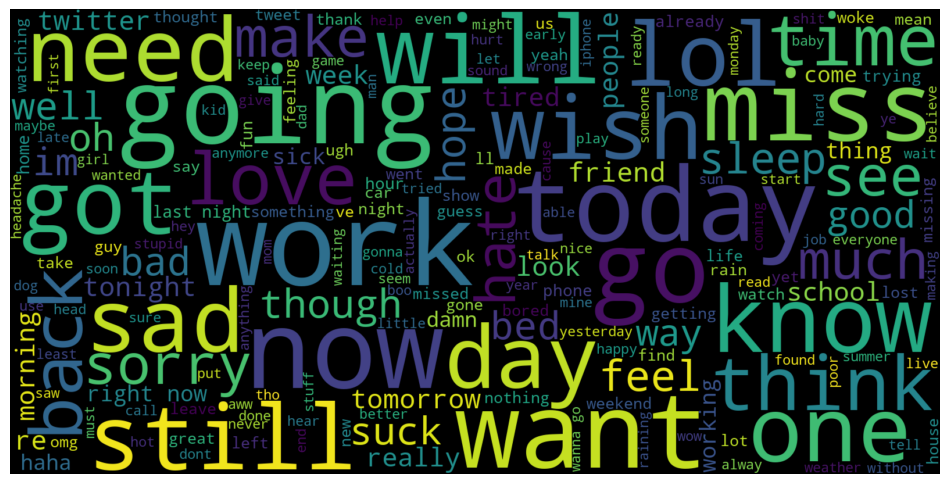

In [25]:
pos_tweets = my_df[my_df.target == 4]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=" ")
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer()

In [27]:
len(cvec.get_feature_names_out())

264939

In [28]:
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 4].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names_out()).transpose()

In [29]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313162,252567,565729
the,257836,265998,523834
my,190775,125955,316730
it,157448,147786,305234
and,153958,149642,303600
you,103844,198245,302089
not,194724,86861,281585
is,133432,111191,244623
in,115542,101160,216702
for,98999,117369,216368


In [30]:
x = my_df.text
y = my_df.target
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=42)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=42)
                                                              

In [31]:
print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),                                                                     (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,                                                                           (len(x_train[y_train == 4]) / (len(x_train)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),                                                                          (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,                                                                       (len(x_validation[y_validation == 4]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),                                                          (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,                                                           (len(x_test[y_test == 4]) / (len(x_test)*1.))*100))

Train set has total 1564120 entries with 50.02% negative, 49.98% positive
Validation set has total 15960 entries with 49.91% negative, 50.09% positive
Test set has total 15961 entries with 49.46% negative, 50.54% positive


In [32]:
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 4 for n in tbresult]

conmat = np.array(confusion_matrix(y_validation, tbpred, labels = [4,0]))

confusion = pd.DataFrame(conmat, index=["positive","negative"],
                        columns = ["predicted_positive", "predicted_negative"])

print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
print ("Classification Report\n")
print (classification_report(y_validation, tbpred))

Accuracy Score: 61.37%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                7188                 806
negative                5359                2607
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.76      0.33      0.46      7966
           4       0.57      0.90      0.70      7994

    accuracy                           0.61     15960
   macro avg       0.67      0.61      0.58     15960
weighted avg       0.67      0.61      0.58     15960



In [33]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [34]:
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n",
feature_result_ug = nfeature_accuracy_checker())

LogisticRegression()


Validation result for 10000 features


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.09%
accuracy score: 79.61%
model is 29.52% more accurate than null accuracy
train and test time: 35.80s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.09%
accuracy score: 79.93%
model is 29.84% more accurate than null accuracy
train and test time: 35.79s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.09%
accuracy score: 80.01%
model is 29.92% more accurate than null accuracy
train and test time: 36.40s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.09%
accuracy score: 79.85%
model is 29.76% more accurate than null accuracy
train and test time: 39.32s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.09%
accuracy score: 80.04%
model is 29.95% more accurate than null accuracy
train and test time: 41.63s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.09%
accuracy score: 79.87%
model is 29.78% more accurate than null accuracy
train and test time: 39.16s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.09%
accuracy score: 80.01%
model is 29.92% more accurate than null accuracy
train and test time: 39.97s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.09%
accuracy score: 80.00%
model is 29.91% more accurate than null accuracy
train and test time: 45.93s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.09%
accuracy score: 80.04%
model is 29.96% more accurate than null accuracy
train and test time: 40.27s
--------------------------------------------------------------------------------
Validation result for 100000 features


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.09%
accuracy score: 80.04%
model is 29.96% more accurate than null accuracy
train and test time: 42.94s
--------------------------------------------------------------------------------


TypeError: 'feature_result_ug' is an invalid keyword argument for print()